In [ ]:
#  Upload and load the dataset

import pandas as pd
from google.colab import files


In [ ]:


# Load the CSV file into a DataFrame
inventory_df = pd.read_csv("inventory.csv")

# Confirm loaded successfully
print("Data loaded! Rows:", len(inventory_df))


Data loaded! Rows: 108


In [ ]:
# Basic data exploration

# Check number of rows and columns
print("Dataset shape:", inventory_df.shape)

# Check for missing values
print("\nMissing values in each column:\n", inventory_df.isnull().sum())

# Show basic info about data types and memory usage
print("\nDataset info:")
print(inventory_df.info())

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(inventory_df.describe())

# Check unique products in the dataset
print("\nUnique products:", inventory_df['PRODUCT_NAME'].unique())


Dataset shape: (108, 6)

Missing values in each column:
 PRODUCT_ID          0
MONTH               0
UNIT_SALES          0
PRODUCT_NAME        0
SUPPLY_TIME         0
QUANTITY_ON_HAND    0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PRODUCT_ID        108 non-null    int64 
 1   MONTH             108 non-null    int64 
 2   UNIT_SALES        108 non-null    int64 
 3   PRODUCT_NAME      108 non-null    object
 4   SUPPLY_TIME       108 non-null    int64 
 5   QUANTITY_ON_HAND  108 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 5.2+ KB
None

Summary statistics:
       PRODUCT_ID       MONTH    UNIT_SALES  SUPPLY_TIME  QUANTITY_ON_HAND
count  108.000000  108.000000    108.000000   108.000000        108.000000
mean     5.000000    6.500000   6371.361111     2.555556         87.361111
std      2

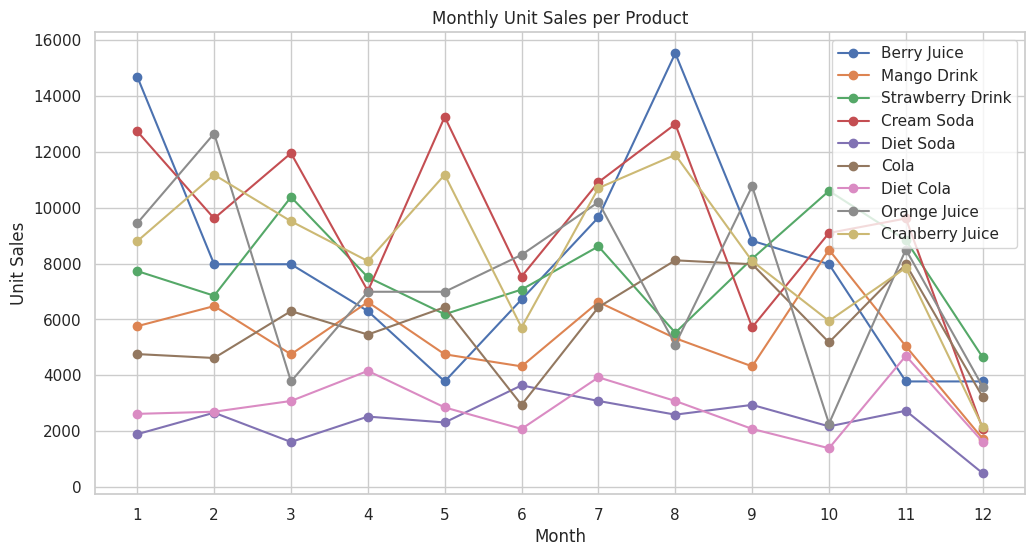

In [ ]:
#Visualize Monthly Sales for Each Product

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot monthly sales trends for each product
plt.figure(figsize=(12, 6))

for product in inventory_df['PRODUCT_NAME'].unique():
    product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product]
    plt.plot(product_data['MONTH'], product_data['UNIT_SALES'], marker='o', label=product)

plt.title('Monthly Unit Sales per Product')
plt.xlabel('Month')
plt.ylabel('Unit Sales')
plt.xticks(range(1, 13))
plt.legend()
plt.show()


In [ ]:
#prepareing dataset for time seires-forecasting


# Filter data for one product
product_name = "Berry Juice"
product_df = inventory_df[inventory_df['PRODUCT_NAME'] == product_name]

# Sort by month just in case
product_df = product_df.sort_values(by='MONTH')

# Reset index
product_df = product_df.reset_index(drop=True)

# Select only month and sales columns
time_series_data = product_df[['MONTH', 'UNIT_SALES']]

print(time_series_data)


    MONTH  UNIT_SALES
0       1       14700
1       2        7980
2       3        7980
3       4        6300
4       5        3780
5       6        6720
6       7        9660
7       8       15540
8       9        8820
9      10        7980
10     11        3780
11     12        3780


In [ ]:
# Forecast Monthly Sales Using ARIMA

In [ ]:
!pip install statsmodels


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


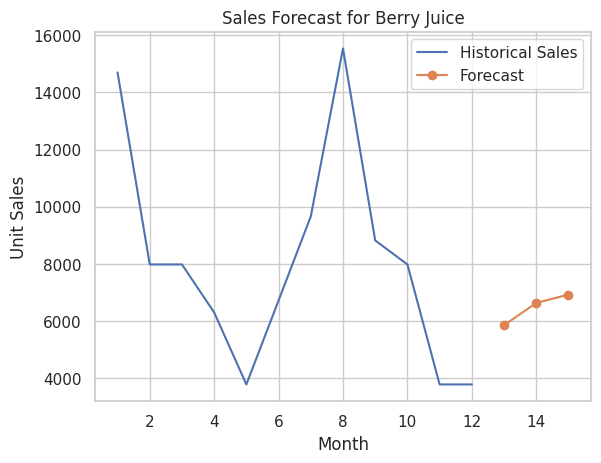

Forecasted sales for next 3 months: [5852.86514361 6632.12549405 6925.07590409]


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Use the time_series_data from the previous step
sales = time_series_data['UNIT_SALES'].values

# Fit ARIMA model (p=1, d=1, q=1) - simple parameters for demo
model = ARIMA(sales, order=(1,1,1))
model_fit = model.fit()

# Forecast next 3 months
forecast = model_fit.forecast(steps=3)

# Plot historical sales and forecast
plt.plot(range(1, len(sales)+1), sales, label='Historical Sales')
plt.plot(range(len(sales)+1, len(sales)+4), forecast, label='Forecast', marker='o')
plt.xlabel('Month')
plt.ylabel('Unit Sales')
plt.title(f'Sales Forecast for {product_name}')
plt.legend()
plt.show()

print("Forecasted sales for next 3 months:", forecast)


In [ ]:
# Calculation of 1)Estimated fututre demand (using forecast)
# Calculation of 2)Current quantity on hand
# 3)Reorder
# Get current quantity on hand for the product (latest month)
current_stock = product_df.loc[product_df['MONTH'] == product_df['MONTH'].max(), 'QUANTITY_ON_HAND'].values[0]

# Sum of forecasted sales for next 3 months (expected demand)
expected_demand = forecast.sum()

# Supply time for the product
supply_time = product_df['SUPPLY_TIME'].values[0]

print(f"Current stock: {current_stock}")
print(f"Expected demand for next 3 months: {expected_demand:.0f}")
print(f"Supply time (months): {supply_time}")

# Calculate reorder point: when stock < expected demand + safety stock (let's say 10% of expected demand)
safety_stock = 0.1 * expected_demand
reorder_point = expected_demand + safety_stock

if current_stock < reorder_point:
    print(" Reorder needed soon! Stock is below reorder point.")
else:
    print(" Stock level is sufficient for the forecasted demand.")






Current stock: 230
Expected demand for next 3 months: 19410
Supply time (months): 3
 Reorder needed soon! Stock is below reorder point.


In [ ]:
# Using Regression Model (Random Forest) to predict sales
# using features like month, supply_time , quantity_on_hand


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Prepare features and target
features = product_df[['MONTH', 'SUPPLY_TIME', 'QUANTITY_ON_HAND']]
target = product_df['UNIT_SALES']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
predictions = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on test data: {mae:.2f}")

# Show predicted vs actual
result_df = X_test.copy()
result_df['Actual_Unit_Sales'] = y_test
result_df['Predicted_Unit_Sales'] = predictions
print(result_df)



Mean Absolute Error on test data: 1712.20
    MONTH  SUPPLY_TIME  QUANTITY_ON_HAND  Actual_Unit_Sales  \
10     11            3                47               3780   
9      10            3                66               7980   
0       1            3                11              14700   

    Predicted_Unit_Sales  
10                6783.0  
9                 8265.6  
0                12852.0  


In [ ]:
# Predict Future Sales & Suggest Reorder Quantities
import numpy as np

# Prepare future months data for prediction (next 3 months)
last_month = product_df['MONTH'].max()
future_months = np.array([last_month + i for i in range(1, 4)])

# Create DataFrame for future prediction inputs
future_data = pd.DataFrame({
    'MONTH': future_months,
    'SUPPLY_TIME': product_df['SUPPLY_TIME'].iloc[0],  # same supply time
    'QUANTITY_ON_HAND': product_df['QUANTITY_ON_HAND'].iloc[-1]  # current stock
})

# Predict future unit sales
future_sales_pred = model.predict(future_data)

print("Predicted sales for next 3 months:", future_sales_pred)

# Calculate reorder suggestion (sum of forecast - current stock + safety stock)
total_predicted_sales = future_sales_pred.sum()
current_stock = product_df['QUANTITY_ON_HAND'].iloc[-1]
safety_stock = 0.1 * total_predicted_sales
reorder_qty = total_predicted_sales + safety_stock - current_stock

print(f"Current stock: {current_stock}")
print(f"Recommended reorder quantity (including 10% safety stock): {max(0, reorder_qty):.0f}")



Predicted sales for next 3 months: [5901. 5901. 5901.]
Current stock: 230
Recommended reorder quantity (including 10% safety stock): 19243


In [ ]:
# Automate Reorder Alerts for All Products

# List unique products
unique_products = inventory_df['PRODUCT_NAME'].unique()

for product in unique_products:
    product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product].sort_values('MONTH').reset_index(drop=True)

    # Prepare features and target
    features = product_data[['MONTH', 'SUPPLY_TIME', 'QUANTITY_ON_HAND']]
    target = product_data['UNIT_SALES']

    # Train model (Random Forest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(features, target)

    # Prepare future months for prediction
    last_month = product_data['MONTH'].max()
    future_months = np.array([last_month + i for i in range(1, 4)])
    future_data = pd.DataFrame({
        'MONTH': future_months,
        'SUPPLY_TIME': product_data['SUPPLY_TIME'].iloc[0],
        'QUANTITY_ON_HAND': product_data['QUANTITY_ON_HAND'].iloc[-1]
    })

    # Predict future sales
    future_sales_pred = model.predict(future_data)

    total_predicted_sales = future_sales_pred.sum()
    current_stock = product_data['QUANTITY_ON_HAND'].iloc[-1]
    safety_stock = 0.1 * total_predicted_sales
    reorder_qty = total_predicted_sales + safety_stock - current_stock

    # Alert
    if reorder_qty > 0:
        print(f" Reorder needed for {product}: Order approx {reorder_qty:.0f} units")
    else:
        print(f" Stock sufficient for {product}")


 Reorder needed for Berry Juice: Order approx 14961 units
 Reorder needed for Mango Drink: Order approx 8581 units
 Reorder needed for Strawberry Drink: Order approx 16929 units
 Reorder needed for Cream Soda: Order approx 11028 units
 Reorder needed for Diet Soda: Order approx 3134 units
 Reorder needed for Cola: Order approx 13896 units
 Reorder needed for Diet Cola: Order approx 6288 units
 Reorder needed for Orange Juice: Order approx 14969 units
 Reorder needed for Cranberry Juice: Order approx 12109 units


In [ ]:
# Save Reorder Alerts to CSV
alerts = []

for product in unique_products:
    product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product].sort_values('MONTH').reset_index(drop=True)
    features = product_data[['MONTH', 'SUPPLY_TIME', 'QUANTITY_ON_HAND']]
    target = product_data['UNIT_SALES']
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(features, target)

    last_month = product_data['MONTH'].max()
    future_months = np.array([last_month + i for i in range(1, 4)])
    future_data = pd.DataFrame({
        'MONTH': future_months,
        'SUPPLY_TIME': product_data['SUPPLY_TIME'].iloc[0],
        'QUANTITY_ON_HAND': product_data['QUANTITY_ON_HAND'].iloc[-1]
    })

    future_sales_pred = model.predict(future_data)
    total_predicted_sales = future_sales_pred.sum()
    current_stock = product_data['QUANTITY_ON_HAND'].iloc[-1]
    safety_stock = 0.1 * total_predicted_sales
    reorder_qty = total_predicted_sales + safety_stock - current_stock

    alerts.append({
        'PRODUCT_NAME': product,
        'Current_Stock': current_stock,
        'Predicted_Sales_Next_3_Months': round(total_predicted_sales, 2),
        'Recommended_Reorder_Quantity': max(0, round(reorder_qty, 2)),
        'Reorder_Needed': 'Yes' if reorder_qty > 0 else 'No'
    })

alerts_df = pd.DataFrame(alerts)
alerts_df.to_csv('reorder_alerts.csv', index=False)
print("Reorder alerts saved to reorder_alerts.csv")



Reorder alerts saved to reorder_alerts.csv


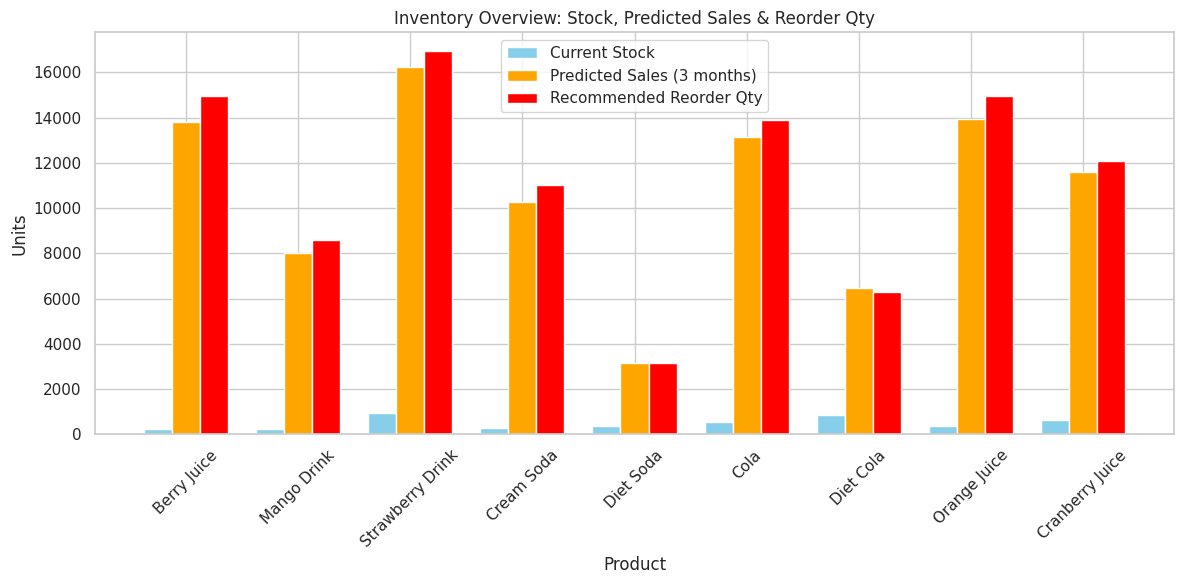

In [ ]:
#  creating  bar charts using matplotlib and seaborn for a clear visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot current stock vs predicted sales vs reorder quantity
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = range(len(alerts_df))

plt.bar(index, alerts_df['Current_Stock'], bar_width, label='Current Stock', color='skyblue')
plt.bar([i + bar_width for i in index], alerts_df['Predicted_Sales_Next_3_Months'], bar_width, label='Predicted Sales (3 months)', color='orange')
plt.bar([i + 2*bar_width for i in index], alerts_df['Recommended_Reorder_Quantity'], bar_width, label='Recommended Reorder Qty', color='red')

plt.xlabel('Product')
plt.ylabel('Units')
plt.title('Inventory Overview: Stock, Predicted Sales & Reorder Qty')
plt.xticks([i + bar_width for i in index], alerts_df['PRODUCT_NAME'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Evaluation of Model Performance Using Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for product in unique_products:
    product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product].sort_values('MONTH').reset_index(drop=True)
    features = product_data[['MONTH', 'SUPPLY_TIME', 'QUANTITY_ON_HAND']]
    target = product_data['UNIT_SALES']

    # Split data into train/test sets (e.g., last 3 months as test)
    train_features = features[:-3]
    train_target = target[:-3]
    test_features = features[-3:]
    test_target = target[-3:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_features, train_target)
    predictions = model.predict(test_features)

    mae = mean_absolute_error(test_target, predictions)
    mse = mean_squared_error(test_target, predictions)
    rmse = np.sqrt(mse)

    print(f"Performance for {product}:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}\n")


Performance for Berry Juice:
MAE: 3512.60, MSE: 16236014.76, RMSE: 4029.39

Performance for Mango Drink:
MAE: 2249.76, MSE: 6707417.93, RMSE: 2589.87

Performance for Strawberry Drink:
MAE: 2090.66, MSE: 4540457.98, RMSE: 2130.84

Performance for Cream Soda:
MAE: 2581.80, MSE: 9326891.43, RMSE: 3054.00

Performance for Diet Soda:
MAE: 1192.80, MSE: 2330480.51, RMSE: 1526.59

Performance for Cola:
MAE: 2419.20, MSE: 8128809.92, RMSE: 2851.11

Performance for Diet Cola:
MAE: 1712.99, MSE: 3418077.59, RMSE: 1848.80

Performance for Orange Juice:
MAE: 3888.99, MSE: 22324009.22, RMSE: 4724.83

Performance for Cranberry Juice:
MAE: 4263.37, MSE: 25432831.24, RMSE: 5043.10



In [ ]:
# Build and Train an LSTM Model for Sales Prediction

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to create sequences for LSTM
def create_sequences(data, seq_length=3):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Choose one product to start with, e.g., 'Berry Juice'
product = 'Berry Juice'
product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product].sort_values('MONTH')

# Use UNIT_SALES for sequence data
sales_data = product_data['UNIT_SALES'].values.reshape(-1, 1)

# Scale data between 0 and 1
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales_data)

# Create sequences
SEQ_LENGTH = 3
X, y = create_sequences(sales_scaled, SEQ_LENGTH)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X, y, epochs=100, verbose=1)

# Predict next 3 months sales
input_seq = sales_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
predictions_scaled = []

for _ in range(3):
    pred = model.predict(input_seq)[0, 0]
    predictions_scaled.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

print(f"Predicted next 3 months sales for {product}: {predictions}")



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1719
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1682
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1646
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1611
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1577
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1545
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1513
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1482
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1453
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1425
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1397
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1371
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1345
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1321
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1298
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━

In [ ]:
#  train an LSTM on its sales, predict next 3 months, and calculate reorder quantity
alerts_lstm = []

for product in unique_products:
    product_data = inventory_df[inventory_df['PRODUCT_NAME'] == product].sort_values('MONTH')
    sales_data = product_data['UNIT_SALES'].values.reshape(-1, 1)

    # Scale sales
    scaler = MinMaxScaler()
    sales_scaled = scaler.fit_transform(sales_data)

    # Create sequences
    X, y = create_sequences(sales_scaled, SEQ_LENGTH)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build and train LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, verbose=0)

    # Predict next 3 months
    input_seq = sales_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
    predictions_scaled = []
    for _ in range(3):
        pred = model.predict(input_seq)[0, 0]
        predictions_scaled.append(pred)
        input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
    total_predicted_sales = predictions.sum()
    current_stock = product_data['QUANTITY_ON_HAND'].iloc[-1]
    safety_stock = 0.1 * total_predicted_sales
    reorder_qty = total_predicted_sales + safety_stock - current_stock

    alerts_lstm.append({
        'PRODUCT_NAME': product,
        'Current_Stock': current_stock,
        'Predicted_Sales_Next_3_Months_LSTM': round(total_predicted_sales, 2),
        'Recommended_Reorder_Quantity_LSTM': max(0, round(reorder_qty, 2)),
        'Reorder_Needed_LSTM': 'Yes' if reorder_qty > 0 else 'No'
    })

alerts_lstm_df = pd.DataFrame(alerts_lstm)
alerts_lstm_df.to_csv('reorder_alerts_lstm.csv', index=False)
print("LSTM-based reorder alerts saved to reorder_alerts_lstm.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM-based reorder alerts saved to reorder_alerts_lstm.csv


<ipython-input-20-da49a404ca61>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=alerts_lstm_df, x='PRODUCT_NAME', y='Recommended_Reorder_Quantity_LSTM', palette='coolwarm')


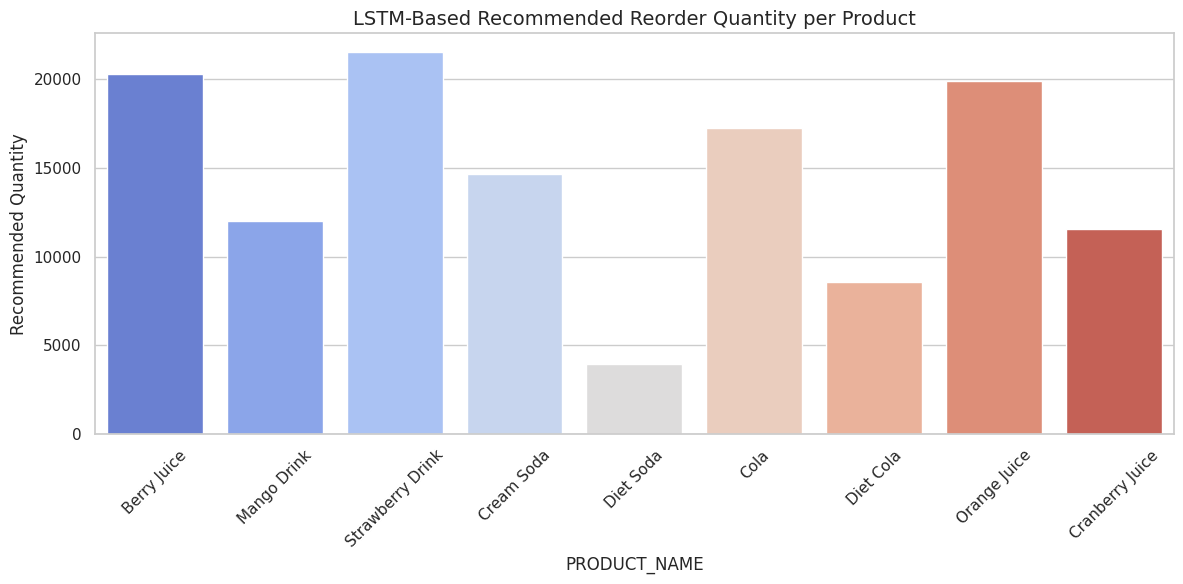

In [ ]:
#Visualize LSTM-Based Reorder Recommendations
import matplotlib.pyplot as plt
import seaborn as sns

# Load the LSTM reorder alerts file
alerts_lstm_df = pd.read_csv('reorder_alerts_lstm.csv')

# Set visual style
sns.set(style="whitegrid")

# Plot: Reorder Recommendation
plt.figure(figsize=(12, 6))
sns.barplot(data=alerts_lstm_df, x='PRODUCT_NAME', y='Recommended_Reorder_Quantity_LSTM', palette='coolwarm')
plt.title("LSTM-Based Recommended Reorder Quantity per Product", fontsize=14)
plt.ylabel("Recommended Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# i am generating report as well
from tabulate import tabulate

# Display summary table in notebook
summary = alerts_lstm_df[['PRODUCT_NAME', 'Current_Stock',
                          'Predicted_Sales_Next_3_Months_LSTM',
                          'Recommended_Reorder_Quantity_LSTM',
                          'Reorder_Needed_LSTM']]

print(tabulate(summary, headers='keys', tablefmt='pretty'))


+---+------------------+---------------+------------------------------------+-----------------------------------+---------------------+
|   |   PRODUCT_NAME   | Current_Stock | Predicted_Sales_Next_3_Months_LSTM | Recommended_Reorder_Quantity_LSTM | Reorder_Needed_LSTM |
+---+------------------+---------------+------------------------------------+-----------------------------------+---------------------+
| 0 |   Berry Juice    |      230      |              18617.96              |             20249.76              |         Yes         |
| 1 |   Mango Drink    |      220      |              11091.34              |             11980.47              |         Yes         |
| 2 | Strawberry Drink |      946      |              20381.67              |             21473.83              |         Yes         |
| 3 |    Cream Soda    |      298      |              13578.13              |             14637.94              |         Yes         |
| 4 |    Diet Soda     |      356      |        

In [ ]:
# PRoject included all below points

#Cleaned and visualized data
# Time-series forecasting with LSTM
# Reorder alerts for each product
# Visualization of inventory needs
# (Optional) Exported results to CSV and shown in reports


# I used  many python librarires pandas, numpy,matplot,seaborn,sklearn,tenserflow.keras,tabulate
# I used machine learning and deep learning concepts like data Preprocessing , time series forecasting , lstm ,  feature scaling , prediction and inventory alert system